In [ ]:
# prompt: 구글드라이브 연동

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -qq diffusers==0.31

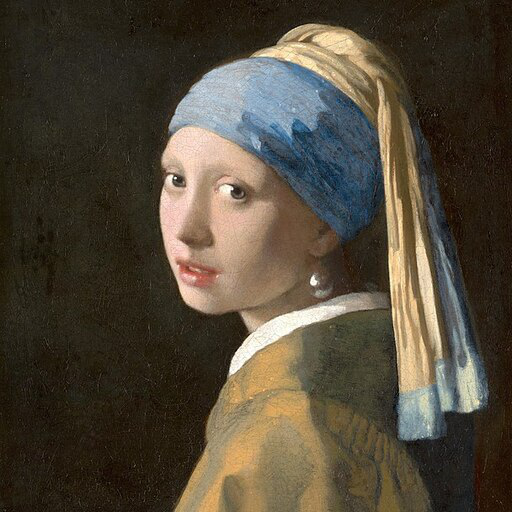

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

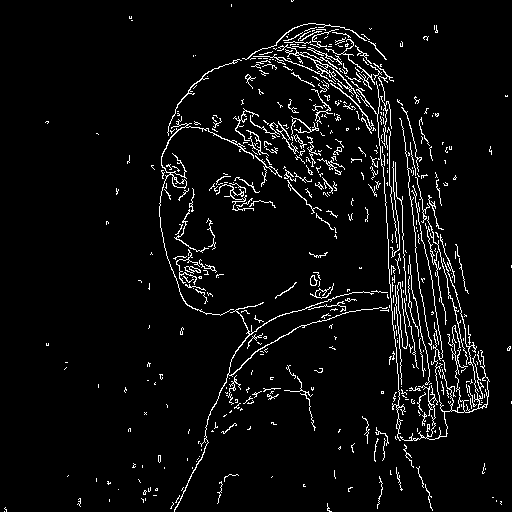

In [ ]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

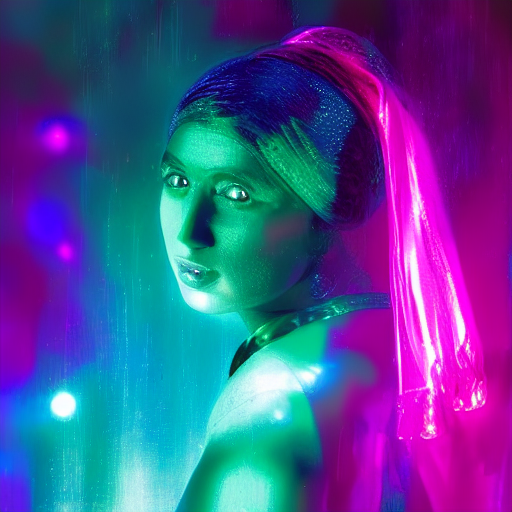

In [ ]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("/content/drive/MyDrive/aiffel/canny_image.png")

# 생성된 이미지를 출력합니다.
canny_image

  0%|          | 0/30 [00:00<?, ?it/s]

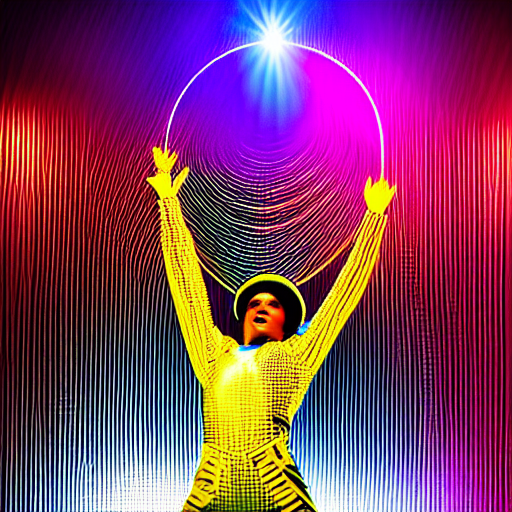

In [ ]:
#부정적인 프로프트

# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.
# [[YOUR CODE]]
from diffusers import UniPCMultistepScheduler

# 스케줄러 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# seed 고정
generator = torch.manual_seed(42)

# 프롬프트 + 부정 프롬프트
prompt = "a vibrant disco dancer, wearing shiny clothes, surrounded by colorful neon lights, 1980s retro style, high energy, dramatic lighting"
negative_prompt = "low quality, blurry, extra limbs, distorted face, low resolution, bad anatomy, poorly drawn"

# 이미지 생성
canny_image = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,         # 조금 더 정교한 결과를 위해 증가
    guidance_scale=7.5,             # 텍스트 프롬프트 반영 강도
    generator=generator,
    image=canny_image
).images[0]

# 저장
canny_image.save("/content/drive/MyDrive/aiffel/canny_image.png")

# 출력
canny_image

## 인체자세감지

In [ ]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

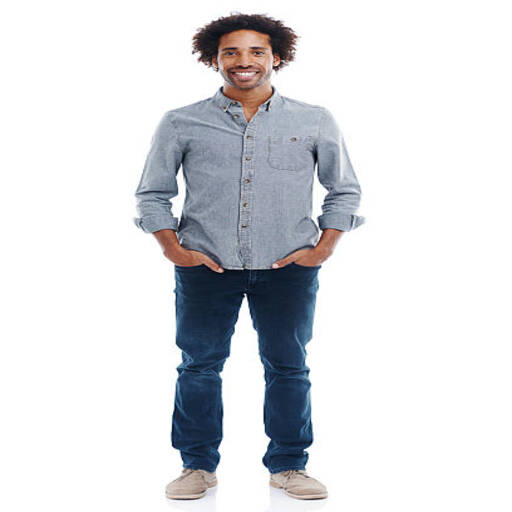

In [ ]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


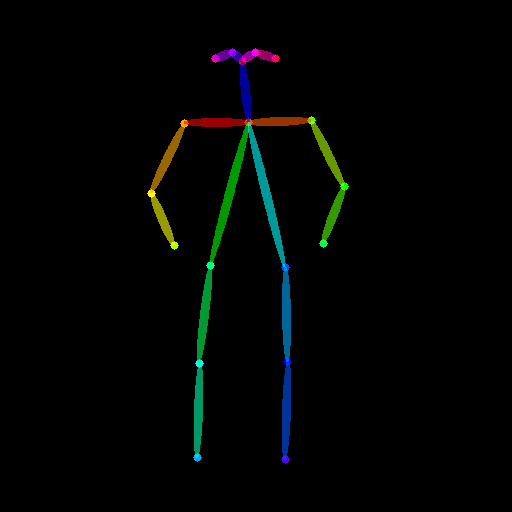

In [ ]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [ ]:
#Openpose 전처리기를 사용한 모델 파이프라인

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

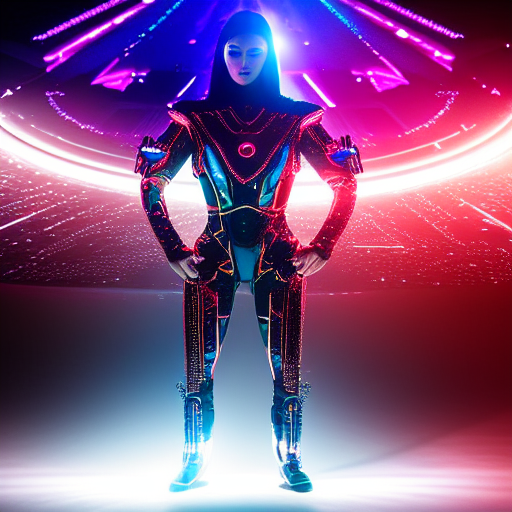

In [ ]:
from diffusers import UniPCMultistepScheduler
import torch

# 스케줄러 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# ✅ seed 고정
generator = torch.manual_seed(42)

# ✅ 프롬프트 설정
prompt = "a futuristic cyborg dancer, dynamic pose, surrounded by holographic light effects, sci-fi background, 4k, ultra realistic"
negative_prompt = "blurry, extra limbs, bad anatomy, low resolution, poorly drawn hands"

# ✅ 이미지 생성 (openpose_image가 이미 존재한다고 가정)
images = openpose_image  # 일반적으로 pose 전처리로 얻은 이미지

openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=images,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator,
).images[0]

# ✅ 출력
openpose_image1

  0%|          | 0/35 [00:00<?, ?it/s]

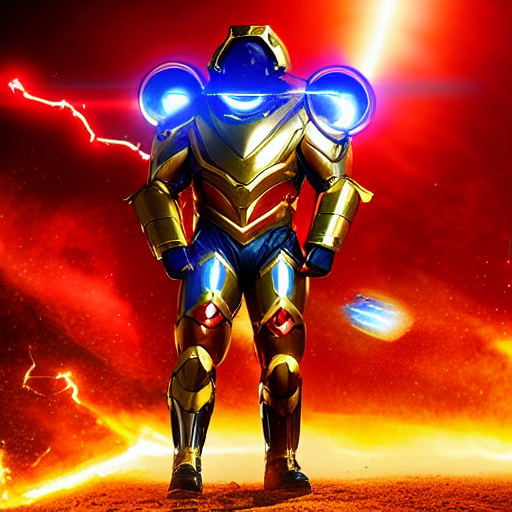

In [ ]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.
# [[YOUR CODE]]
from diffusers import UniPCMultistepScheduler
import torch

# 스케줄러 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# seed 고정
generator = torch.manual_seed(777)

# ✅ 프롬프트
prompt = (
    "a dramatic battle between a man in a red and gold high-tech armor suit shooting energy blasts, "
    "and a muscular soldier with a blue outfit and a round shield, intense action scene, comic book style, "
    "explosions, sparks, dynamic poses, cinematic lighting, detailed environment"
)

# ✅ 부정 프롬프트
negative_prompt = (
    "black and white, grayscale, low contrast, blurry, bad anatomy, extra limbs, distorted hands, text, watermark"
)

# ✅ 이미지 생성
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=openpose_image,  # 포즈 정보가 담긴 이미지
    num_inference_steps=35,   # 디테일 강조
    guidance_scale=8.5,       # 텍스트 반영 강도 중간 이상
    generator=generator,
).images[0]

# ✅ 출력
openpose_image1

In [ ]:
## 윤곽선 검출 + 인체 자세 감지

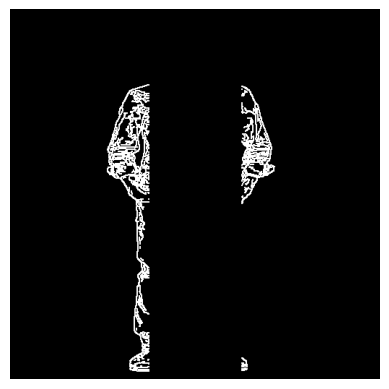

In [ ]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드
canny_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")
canny_image = np.array(canny_image.convert("RGB"))

# 그레이스케일
gray = cv2.cvtColor(canny_image, cv2.COLOR_RGB2GRAY)

# ✅ Canny 감지 (threshold 낮추는걸로 조정
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(gray, low_threshold, high_threshold)

# ✅ 중앙 제거 범위 좁게
h, w = edges.shape
zero_start = w // 2 - w // 8
zero_end = w // 2 + w // 8
edges[:, zero_start:zero_end] = 0

# ✅ 선 굵게 보이도록 dilation
kernel = np.ones((2, 2), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

# 3채널로 변환 후 PIL 이미지로
canny_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
canny_image = Image.fromarray(canny_image)

# 출력
plt.imshow(canny_image)
plt.axis("off")
plt.show()

In [ ]:
# 그냥 검은색 화면으로만 나와서 threshold 조정하여서 진행

cuda


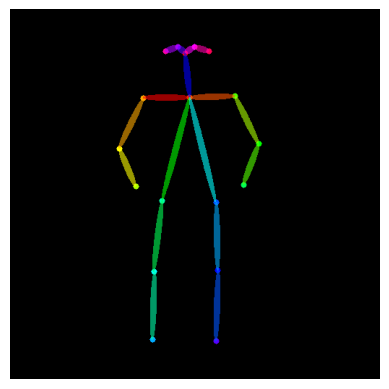

In [ ]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# 1. 원본 이미지 로드
image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# 2. OpenPoseDetector 모델 로드
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 3. 포즈 이미지 추출 (이미 PIL.Image 형식으로 리턴됨)
openpose_image = openpose(image)

# 4. 이미지 출력
plt.imshow(openpose_image)
plt.axis("off")
plt.show()

Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달합니다.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

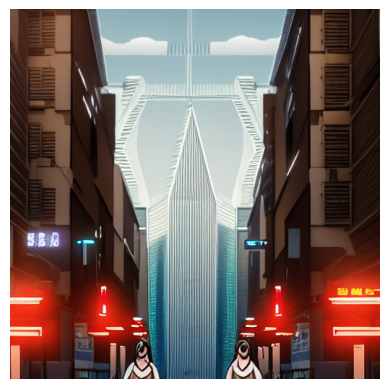

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch

# 1. ControlNet 모델 2개 로드 (Canny + Openpose)
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
]

# 2. ControlNet 모델 리스트로 파이프라인 구성
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

# 3. 스케줄러 설정 및 디바이스 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 4. 프롬프트 설정
prompt = "a futuristic warrior girl standing in a city street, highly detailed, anime style, cinematic lighting"
negative_prompt = "blurry, low quality, extra limbs, distorted face, watermark, text"

# 5. 시드 고정
generator = torch.Generator(device="cuda").manual_seed(42)

# 6. Canny + Openpose 이미지 입력
images = [openpose_image, canny_image]

# 7. 이미지 생성
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=images,
    generator=generator,
    num_inference_steps=30,
    guidance_scale=8.5
).images[0]

# 8. 이미지 저장
image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output.png")


# 9. 이미지 출력 (PIL 대신 matplotlib 사용)
plt.imshow(image)
plt.axis("off")
plt.show()

## 회고
천주호 

### 배운점 : stable diffusion 의 모델을 설정하고 구축하는 방법  
### 아쉬운점 : 실제 퀄리티가 아쉽게 나왔다
### 느낀점 : 이제는 아무렇지 않게 사용하는 이미지 생성이 이렇게 복잡한 과정을 통해 얻어지는것이고 , 자연어로 단순히 설정하는것이 아니라 코딩을 통해서 파라미터를 설정해주고 조정할수있는게 신기했고, 이것에 대해 원리를 자세히 알고있으면 내가 생성형 ai를 다루는것에 좀더 전문적일수있겠다 생각했습니다
### 어려웠던점 : 항상 경로문제,, 경로가 꼬일때가 있었습니다


김의훈



### 배운 점
텍스트로 이미지를 생성하는 방법과 디퓨전 모델을 활용한 이미지 생성 기법을 배웠다.

스테이블 디퓨전과 같은 이미지 생성형 AI 모델들이 어떻게 동작하는지, 그리고 그 모델들이 윤곽을 따서 이미지를 생성하는 방식을 이해할 수 있었다.

현재의 AI 모델들이 이러한 기술들을 기반으로 발전하면서 비약적인 성장을 이루었음을 실감했다.

### 아쉬운 점
텍스트로 이미지 생성하는 과정에서 일부 결과물이 기대와 다르게 나올 때가 있었다. 특히, 특정 세부 사항을 묘사하기 어려운 경우가 있었고, 여러 번 시도해야 원하는 이미지를 얻을 수 있었다.

또한, 모델의 응답 속도나 자원 소모 측면에서 개선이 필요해 보였고, 때로는 예기치 않은 결과가 나오는 경우가 있었다.

### 느낀 점
전체적으로 매우 흥미로운 프로젝트였다. AI 모델이 텍스트를 통해 이미지를 창조하는 능력은 매우 혁신적이며, 상상력의 범위가 넓어지는 것 같았다.

이러한 기술이 발전하면서 창의력의 표현 방식도 점점 더 다양해지고 있다는 것을 느꼈다.

### 어려웠던 점
텍스트에서 세부적인 이미지를 정확하게 묘사하는 것이 생각보다 어려웠다. 특정 색상이나 구체적인 형태를 명확히 지정하려고 해도 모델이 이를 잘 반영하지 못할 때가 많았다.

또한, 디퓨전 모델의 설정과 하이퍼파라미터 튜닝이 복잡하게 느껴졌으며, 여러 번의 실험을 통해 적절한 파라미터를 찾는 과정이 번거로웠다.